### Simple CNN to classify playing cards
by Jacob Igo

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

print(torch.cuda.is_available())
print(f"Current GPU device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

True
Current GPU device name: NVIDIA GeForce GTX 1650 with Max-Q Design


Creating the Model Architecture

In [43]:
class CardNet(nn.Module):
    def __init__(self, num_classes=14):
        super(CardNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Creating the Card Dataset Class

In [44]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from PIL import Image


class CardDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform=transform)
        self.value_mapping = self._extract_card_value()

    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        image, old_label = self.data[index]
        card_name = self.data.classes[old_label]
        value_label = self.value_mapping[card_name]
        return image, value_label
    
    def _extract_card_value(self):
        value_map = {}
        value_names = ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 
                      'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'joker']
        
        for class_name in self.data.classes:
            class_lower = class_name.lower()
            for i, value in enumerate(value_names):
                if value in class_lower:
                    value_map[class_name] = i
                    break
            else:
                # Handle edge cases or unknown cards
                value_map[class_name] = 13  # Default to joker category
                
        return value_map
    
    @property
    def classes(self):
        return ['ace', 'two', 'three', 'four', 'five', 'six', 'seven', 
                'eight', 'nine', 'ten', 'jack', 'queen', 'king', 'joker']

train_dir = r'C:\Users\jacob\card-counting-dataset\archive_1\train'
train_set = CardDataset(data_dir = train_dir)

target_to_class = {i: name for i, name in enumerate(train_set.classes)}
print(target_to_class)


{0: 'ace', 1: 'two', 2: 'three', 3: 'four', 4: 'five', 5: 'six', 6: 'seven', 7: 'eight', 8: 'nine', 9: 'ten', 10: 'jack', 11: 'queen', 12: 'king', 13: 'joker'}


Creating the DataLoaders

In [51]:
tranform_vt = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_dir = r'C:\Users\jacob\card-counting-dataset\archive_1\train'
val_dir = r'C:\Users\jacob\card-counting-dataset\archive_1\valid'
test_dir = r'C:\Users\jacob\card-counting-dataset\archive_1\test'

train_set = CardDataset(train_dir, transform=train_transform)
val_set = CardDataset(val_dir, transform=tranform_vt)
test_set = CardDataset(test_dir, transform=tranform_vt)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.73333335].


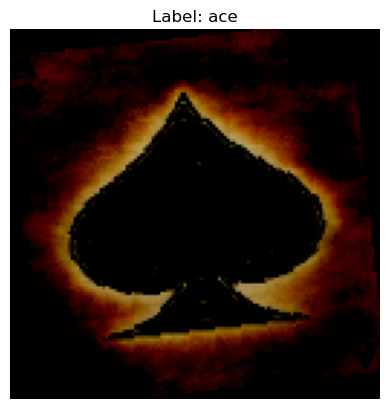

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

images, labels = next(iter(train_loader))
image = images[0]
label = labels[0]

image_to_display = image.permute(1, 2, 0)
image_to_display_np = image_to_display.cpu().numpy()
plt.imshow(image_to_display_np)
plt.title(f"Label: {target_to_class[label.item()]}")
plt.axis('off')  # Hide axes for cleaner display
plt.show()

Model Training

In [ ]:
model = CardNet()
#model = models.resnet18(weights='IMAGENET1K_V1')
#model.fc = nn.Linear(model.fc.in_features, 14)
model.train()

device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

train_loss, val_loss, train_acc, val_acc = [], [], [], []

EPOCHS = 7
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.00075)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
criterion = nn.CrossEntropyLoss()


for epoch in range(0, EPOCHS):
    model.train()
    total_samples_t, correct_predictions_t, running_loss_t = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        image, label = data

        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()

        outputs = model(image)

        _, predicted = torch.max(outputs.data, 1)

        loss = criterion(outputs, label)

        loss.backward()

        optimizer.step()

        running_loss_t += loss.item()
        total_samples_t += label.size(0)
        correct_predictions_t += (predicted == label).sum().item()
        train_loss.append(running_loss_t)

    model.eval()
    with torch.no_grad():
        total_samples_v, correct_predictions_v, running_loss_v = 0.0, 0.0, 0.0
        for i, data in enumerate(val_loader):

            image, label = data
            
            image = image.to(device)
            label = label.to(device)

            outputs = model(image)

            _, predicted = torch.max(outputs.data, 1)

            loss = criterion(outputs, label)

            running_loss_v += loss.item()
            total_samples_v += label.size(0)
            correct_predictions_v += (predicted == label).sum().item()
            val_loss.append(running_loss_v)

    
    epoch_avg_loss_t = running_loss_t / len(train_loader)
    epoch_avg_loss_v = running_loss_v / len(val_loader)
    accuracy_t = 100 * correct_predictions_t / total_samples_t
    accuracy_v = 100 * correct_predictions_v / total_samples_v
    
    scheduler.step(accuracy_v)

    train_acc.append(accuracy_t)
    val_acc.append(accuracy_v)
    print(f"Epoch: {epoch+1}/{EPOCHS}, Train avg loss:  {epoch_avg_loss_t:.4f}, Train avg acc: {accuracy_t:.4f} || val avg loss: {epoch_avg_loss_v:.4f}, val avg acc: {accuracy_v:.4f}")



cuda:0
Epoch: 1/7, Train avg loss:  1.1148, Train avg acc: 64.5986 || val avg loss: 0.4272, val avg acc: 85.2830
Epoch: 2/7, Train avg loss:  0.6685, Train avg acc: 78.2529 || val avg loss: 0.2639, val avg acc: 93.2075
Epoch: 3/7, Train avg loss:  0.5096, Train avg acc: 83.1847 || val avg loss: 0.3261, val avg acc: 91.6981
Epoch: 4/7, Train avg loss:  0.4478, Train avg acc: 85.5981 || val avg loss: 0.1878, val avg acc: 94.3396
Epoch: 5/7, Train avg loss:  0.3721, Train avg acc: 87.8017 || val avg loss: 0.1099, val avg acc: 96.6038
Epoch: 6/7, Train avg loss:  0.3286, Train avg acc: 89.5068 || val avg loss: 0.0818, val avg acc: 96.9811
Epoch: 7/7, Train avg loss:  0.2869, Train avg acc: 90.7135 || val avg loss: 0.1203, val avg acc: 96.6038


Testing of the model

In [60]:
model.eval()
with torch.no_grad():
    test_acc, test_count, test_pred = 0.0, 0.0, 0.0
    for i, data in enumerate(test_loader):
        image, label = data

        image = image.to(device)
        label = label.to(device)

        outputs = model(image)

        _, predicted = torch.max(outputs.data, 1)

        test_count += label.size(0)
        test_pred += (predicted == label).sum().item()

accuracy = 100 * test_pred / test_count
print(f"Accuracy: {accuracy}")

Accuracy: 93.9622641509434


Showing Test Examples

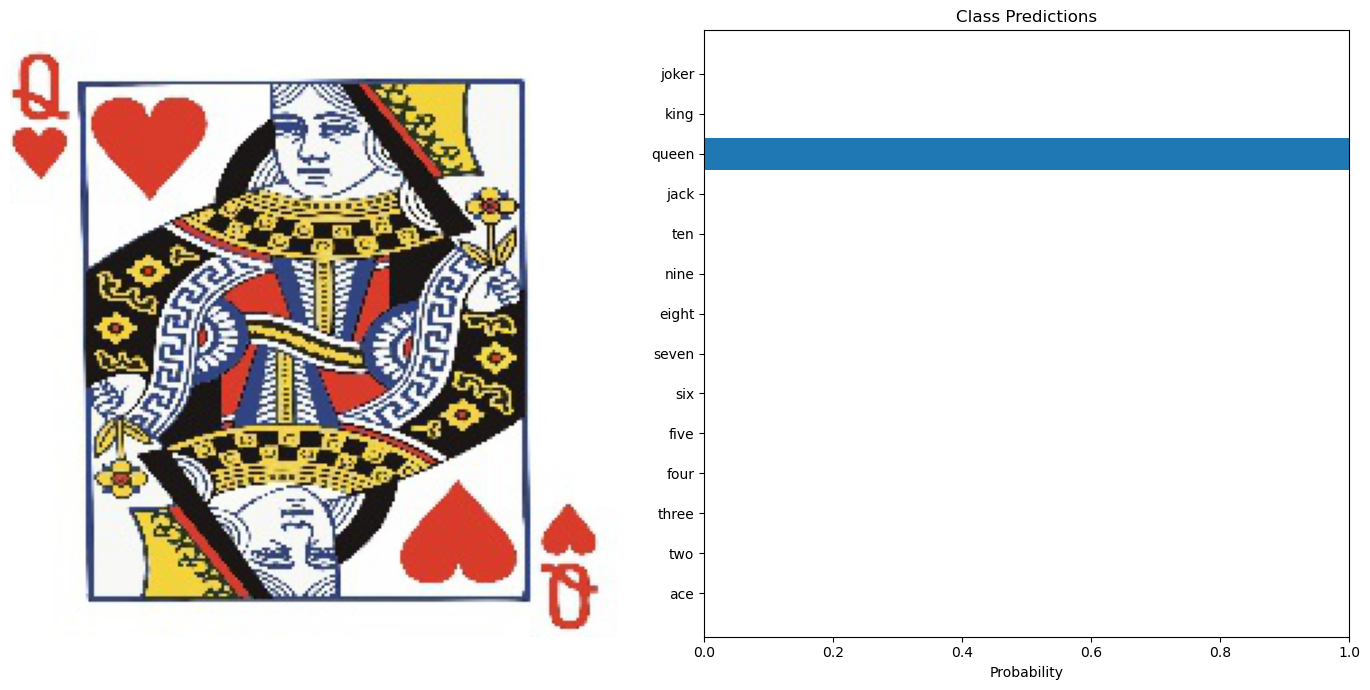

In [62]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)


def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

test_image = r"C:\Users\jacob\card-counting-dataset\archive_1\test\queen of hearts\1.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = train_set.classes
visualize_predictions(original_image, probabilities, class_names)


Saving the Model

In [ ]:
torch.save(model.state_dict(), 'cardnet.pth')